In [132]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('ouirt.dat', sep= ' ', names= cols)
num_users= data.shape[0]

data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*  Truncating Question items to 3

In [3]:
rel_items = cols[:]#Q1,Q2,Q3
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
0,0,1,1,1,1,1,1,1,1,0
1,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,1,1,0,1,0


In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

In [5]:
from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [6]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})


df_new= pd.DataFrame()
for i in range(len(df_list)):
    df = pd.DataFrame(df_list[i])
    df_new= pd.concat([df_new, df], ignore_index=True)

df_new = df_new.loc[np.random.randint(0,df_new.shape[0]-1, size=df_new.shape[0])]#shuffling data
df_new

,user,questions,response
85,85,Q1,0
4821,321,Q10,0
178,178,Q1,0
1204,204,Q3,0
805,305,Q2,0
...,...,...,...
839,339,Q2,0
1376,376,Q3,0
1134,134,Q3,0
4104,104,Q9,0


### Defining Keras equivalent model

In [7]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [8]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [9]:
x_train_user = to_categorical(xtrain['user'], num_classes=500)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (4750, 500) 
shape of x_train_questions: (4750, 10) 
shape of y_train: (4750,)


### 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`

In [10]:
from keras import backend as K
from keras.layers import Lambda
from keras import regularizers
from keras import initializers
from keras.layers import Activation

In [12]:
#for the purpose of Lambda layer
def ops_func(x, op='add'):
    if op=='add':
        return K.constant(value=np.array([x[0]])) + x[1]
    if op=='subtract':
        return K.constant(value=np.array([x[0]])) - x[1]
    if op=='multiply':
        return K.constant(value=np.array([x[0]]))* x[1]

In [12]:
user_input_layer = Input(shape=(x_train_user.shape[1],), name= 'user_id')#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],), name='questions/items')#bottom half of input

#kernel init set to RandomNorm,kernel regularizer set to l2
latent_trait = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        kernel_regularizer=regularizers.l2(0.01), name='latent_trait')(user_input_layer)


difficulty_level = Dense(1, use_bias=False, name='difficulty_level')(quest_input_layer)

#discrimination param set fixed to 1
discrimination_param = Dense(1, use_bias=False, kernel_initializer=initializers.Ones(), trainable=False, name='disc_param')(quest_input_layer)

guess_param = Dense(1, use_bias=False, name='guessing_param')(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract(name='latent_diff_sub')([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply(name='disc_param_inter.')([latent_difficulty_subtract, 
                                                    discrimination_param])

#Sigmoid positioning corrected
sigmoid_layer= Activation('sigmoid', name='Sigmoid_func')(disc_param_interaction)


guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x, name='guess_param_inter.')(guess_param)


guess_param_interaction= keras.layers.Multiply(name='disc/guess_param_inter.')([sigmoid_layer, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add(name='guess_param_inter/add')([guess_param, guess_param_interaction])


# last layer is dummy. it is not trainable, weight =1, bias = 0
prediction_output = Dense(1, activation='softmax',trainable=False,use_bias=False,kernel_initializer=keras.initializers.Ones(), name='prediction_layer')(guess_param_interaction)


model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [13]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 10)           0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            500         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            10          questions/items[0][0]            
____________________________________________________________________________________________

In [14]:
history= model3.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 3800 samples, validate on 950 samples
Epoch 1/8
3800/3800 [==============================] - 0s 72us/step - loss: 16.7794 - mae: 0.7197 - accuracy: 0.2803 - val_loss: 16.3214 - val_mae: 0.6989 - val_accuracy: 0.3011
Epoch 2/8
3800/3800 [==============================] - 0s 23us/step - loss: 16.5328 - mae: 0.7197 - accuracy: 0.2803 - val_loss: 16.0807 - val_mae: 0.6989 - val_accuracy: 0.3011
Epoch 3/8
3800/3800 [==============================] - 0s 24us/step - loss: 16.2976 - mae: 0.7197 - accuracy: 0.2803 - val_loss: 15.8511 - val_mae: 0.6989 - val_accuracy: 0.3011
Epoch 4/8
3800/3800 [==============================] - 0s 23us/step - loss: 16.0734 - mae: 0.7197 - accuracy: 0.2803 - val_loss: 15.6322 - val_mae: 0.6989 - val_accuracy: 0.3011
Epoch 5/8
3800/3800 [==============================] - 0s 25us/step - loss: 15.8596 - mae: 0.7197 - accuracy: 0.2803 - val_loss: 15.4235 - val_mae: 0.6989 - val_accuracy: 0.3011
Epoch 6/8
3800/

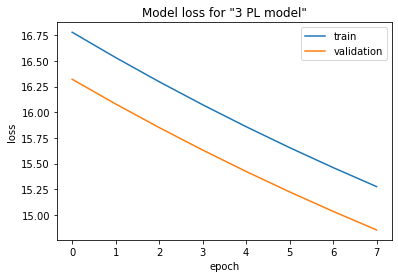

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### Obtaining underlying trained 3pl parameters from model

In [76]:
latent_trait_parameters = model3.layers[2].get_weights()[0]#latent trait for 500 users
difficulty_level_parameters= model3.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= np.ones((len(rel_items),1))#model3.layers[4].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

In [79]:
difficulty_level_parameters

array([[ 0.35855693],
       [ 0.66455823],
       [ 0.28619784],
       [-0.40764207],
       [-0.20665246],
       [ 0.35813254],
       [ 0.03534317],
       [-0.3326103 ],
       [ 0.05360186],
       [ 0.04250133]], dtype=float32)

In [80]:
discrimination_parameters

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [22]:
pseudo_guess_parameters

array([[-0.64500797],
       [ 0.68103164],
       [ 0.47337824],
       [ 0.17807794],
       [-0.15154654],
       [ 0.5972299 ],
       [-0.03532541],
       [ 0.47053474],
       [-0.5494184 ],
       [ 0.12248248]], dtype=float32)

*  histogram for latent traits

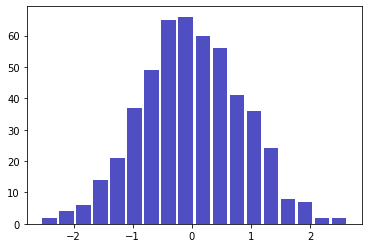

In [24]:
n, bins, patches = plt.hist(x=latent_trait_parameters, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

* Conditional probablities obtained from R's 3PL

In [22]:
con_prob_r= pd.read_csv('cond_vals.csv')
con_prob_r.head(10)

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,1,0.0251,0.1178,0.1055,0.0879,0.1630,0.0750,0.2211,0.0797,0.0475,0.0023
1,2,0.0621,0.1486,0.2092,0.1243,0.3248,0.1790,0.3385,0.1937,0.1466,0.0094
2,3,0.0544,0.1412,0.1900,0.1147,0.2961,0.1584,0.3192,0.1711,0.1249,0.0076
3,4,0.1003,0.1904,0.2922,0.1856,0.4419,0.2733,0.4146,0.2965,0.2551,0.0203
4,5,0.0409,0.1295,0.1537,0.1003,0.2401,0.1210,0.2801,0.1300,0.0878,0.0049
5,6,0.0836,0.1710,0.2579,0.1562,0.3951,0.2335,0.3845,0.2533,0.2078,0.0151
6,7,0.0749,0.1616,0.2390,0.1425,0.3683,0.2120,0.3671,0.2299,0.1831,0.0127
7,8,0.0534,0.1403,0.1874,0.1135,0.2921,0.1556,0.3165,0.1681,0.1220,0.0074
8,9,0.0991,0.1889,0.2898,0.1833,0.4387,0.2704,0.4125,0.2934,0.2517,0.0199
9,10,0.0899,0.1782,0.2713,0.1669,0.4136,0.2488,0.3964,0.2700,0.2258,0.0170


### Importing Key paramters obtained from R's 3PL model

In [25]:
coeff = pd.read_csv('coeffs.csv')
coeff

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000025,1.636048,1.414799
1,V2,0.106400,1.214459,2.006961
2,V3,0.000048,0.817690,1.208465
3,V4,0.079261,0.890029,2.529919
4,V5,0.000037,0.257974,1.352935
5,V6,0.000057,0.746576,1.479909
6,V7,0.000164,0.477205,0.881995
7,V8,0.000003,0.651561,1.526094
8,V9,0.001652,0.656884,1.886512
9,V10,0.000002,1.919147,2.114968


In [26]:
r_params_cols= list(coeff.columns)
r_params_cols#columns from R's dataframe

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* Normalising Difficulty, Descrimination values from R's dataframe

In [28]:
normalized_diff_r=coeff[r_params_cols[2]]#/coeff[r_params_cols[2]].sum()
normalized_diff_r#new difficulty vals from R

0    1.636048
1    1.214459
2    0.817690
3    0.890029
4    0.257974
5    0.746576
6    0.477205
7    0.651561
8    0.656884
9    1.919147
Name: Dffclt, dtype: float64

In [82]:
normalized_desc_r=coeff[r_params_cols[-1]]/coeff[r_params_cols[-1]].sum()
normalized_desc_r#new descrimination vals from R

0    0.086255
1    0.122357
2    0.073675
3    0.154239
4    0.082483
5    0.090224
6    0.053772
7    0.093040
8    0.115013
9    0.128941
Name: Dscrmn, dtype: float64

### Scatterplots: difficulty vals from keras_3pl vs. R_3pl

In [29]:
d1 = (np.array(range(1, len(rel_items)+1)), difficulty_level_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), normalized_diff_r.values)

data_diff= (d1,d2)

In [30]:
d1

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([[ 0.35855693],
        [ 0.66455823],
        [ 0.28619784],
        [-0.40764207],
        [-0.20665246],
        [ 0.35813254],
        [ 0.03534317],
        [-0.3326103 ],
        [ 0.05360186],
        [ 0.04250133]], dtype=float32))

* Solo

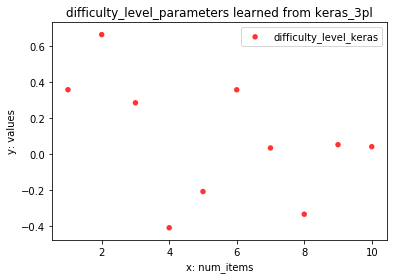

In [32]:
colors = ("red", "blue")
groups = ("difficulty_level_keras", "difficulty_level_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1 
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('difficulty_level_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

* Combined

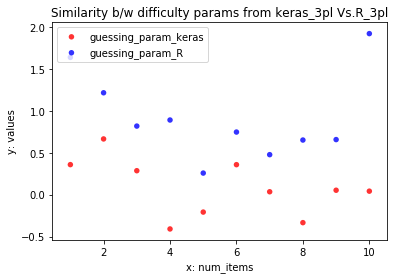

In [83]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_diff, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w difficulty params from keras_3pl Vs.R_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Scatterplot: discrimination vals from keras_3pl vs. R_3pl

In [84]:
d1 = (np.array(range(1, len(rel_items)+1)), discrimination_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), normalized_desc_r.values)

data_desc= (d1,d2)

* Solo

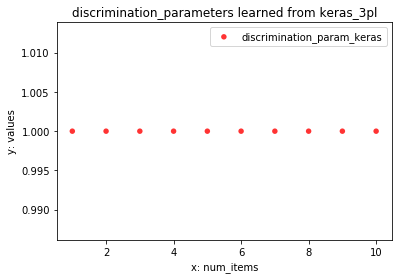

In [85]:
colors = ("red", "blue")
groups = ("discrimination_param_keras", "discrimination_param_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('discrimination_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

* Combined

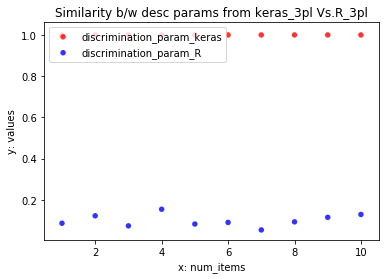

In [86]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_desc, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w desc params from keras_3pl Vs.R_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Scatterplot: guessing_param values from keras_3pl vs. R_3pl

In [87]:
d1 = (np.array(range(1, len(rel_items)+1)), pseudo_guess_parameters)

d2 = (np.array(range(1, len(rel_items)+1)), coeff[r_params_cols[1]].values)

data_guess= (d1,d2)

coeff[r_params_cols[1]]#guessing params from R

0    0.000025
1    0.106400
2    0.000048
3    0.079261
4    0.000037
5    0.000057
6    0.000164
7    0.000003
8    0.001652
9    0.000002
Name: Gussng, dtype: float64

* Solo

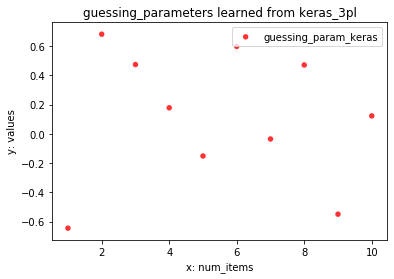

In [35]:
colors = ("red", "blue")
groups = ("guessing_param_keras", "guessing_param_R")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
x,y =d1
ax.scatter(x, y, alpha=0.8, c=colors[0], edgecolors='none', s=30, label=groups[0])
plt.title('guessing_parameters learned from keras_3pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=1)
plt.show()

* Combined

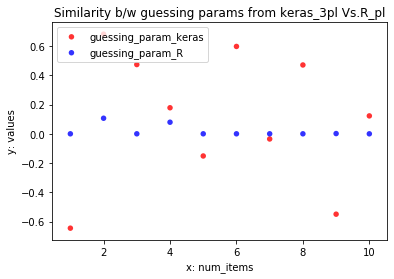

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data_guess, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w guessing params from keras_3pl Vs.R_pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

### Item Characteristic curves from keras_3pl vs. R_3pl

In [37]:
coeff

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.000025,1.636048,1.414799
1,V2,0.106400,1.214459,2.006961
2,V3,0.000048,0.817690,1.208465
3,V4,0.079261,0.890029,2.529919
4,V5,0.000037,0.257974,1.352935
5,V6,0.000057,0.746576,1.479909
6,V7,0.000164,0.477205,0.881995
7,V8,0.000003,0.651561,1.526094
8,V9,0.001652,0.656884,1.886512
9,V10,0.000002,1.919147,2.114968


In [38]:
r_params_cols

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

* Item characterstic plotting function for 3PL

In [152]:
def logit_func(lat_values):#c:guess, a:descrimination, b:difficulty
    prob = list()
    prob.append(c+ (1-c)*(np.exp(a*(lat_values-b))/(1+np.exp(a*(lat_values-b)))))#Vectorised implementation
    #for val in lat_values:
    #    prob.append(c+ (1-c)*(np.exp(a*(val-b))/(1+np.exp(a*(val-b)))))
    return prob

In [153]:
x = np.linspace(-4,4, num=num_users)#value count for x axis

### Individual plots for each item(1-10) across keras method vs. R tpm
* calculating plots for R's item 1 & keras's item 1

In [40]:
coeff[r_params_cols[0]].iloc[0]

'V1'

In [166]:
#values of item 1 from R's dataframe
c= coeff[r_params_cols[1]].iloc[0]#c:guess
a= coeff[r_params_cols[-1]].iloc[0]#a:descrimination
b= coeff[r_params_cols[2]].iloc[0]#b:difficulty
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[0]#values for item 1 from keras 3pl params
a= discrimination_parameters[0]
b= difficulty_level_parameters[0]
vals_keras= logit_func(x)#logits for R's dataframe

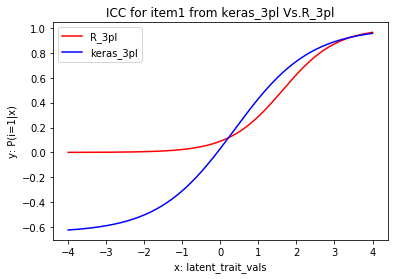

In [167]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item1 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 2 & keras's item 2

In [168]:
coeff[r_params_cols[0]].iloc[1]

'V2'

In [173]:
c= coeff[r_params_cols[1]].iloc[1]#values of item 2 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[1]
b= coeff[r_params_cols[2]].iloc[1]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[1]#values for item 2 from keras 3pl params
a= discrimination_parameters[1]
b= difficulty_level_parameters[1]
vals_keras= logit_func(x)#logits for R's dataframe

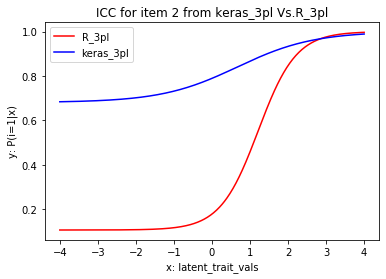

In [46]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 2 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 3

In [47]:
coeff[r_params_cols[0]].iloc[2]

'V3'

In [175]:
c= coeff[r_params_cols[1]].iloc[2]#values of item 3 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[2]
b= coeff[r_params_cols[2]].iloc[2]
vals_r= logit_func(x)#logits for R's dataframe
####
c= pseudo_guess_parameters[2]#values for item 3 from keras 3pl params
a= discrimination_parameters[2]
b= difficulty_level_parameters[2]
vals_keras= logit_func(x)#logits for R's dataframe

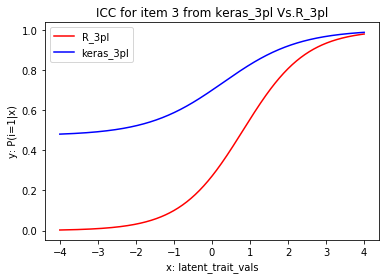

In [49]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 3 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 4

In [50]:
coeff[r_params_cols[0]].iloc[3]

'V4'

In [177]:
c= coeff[r_params_cols[1]].iloc[3]#values of item 4 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[3]
b= coeff[r_params_cols[2]].iloc[3]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[3]#values for item 4 from keras 3pl params
a= discrimination_parameters[3]
b= difficulty_level_parameters[3]
vals_keras= logit_func(x)#logits for R's dataframe

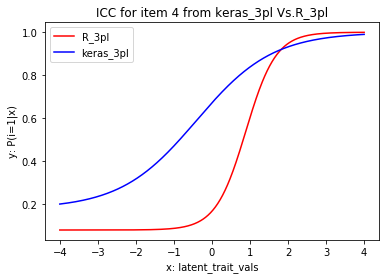

In [178]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 4 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 5

In [53]:
coeff[r_params_cols[0]].iloc[4]

'V5'

In [179]:
c= coeff[r_params_cols[1]].iloc[4]#values of item 5 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[4]
b= coeff[r_params_cols[2]].iloc[4]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[4]#values for item 5 from keras 3pl params
a= discrimination_parameters[4]
b= difficulty_level_parameters[4]
vals_keras= logit_func(x)#logits for R's dataframe

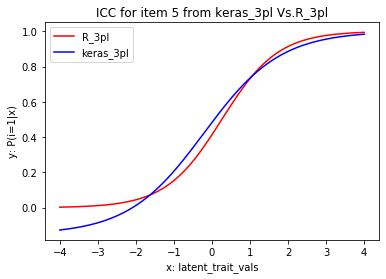

In [180]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 5 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 6

In [57]:
coeff[r_params_cols[0]].iloc[5]

'V6'

In [181]:
c= coeff[r_params_cols[1]].iloc[5]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[5]
b= coeff[r_params_cols[2]].iloc[5]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[5]#values for item 6 from keras 3pl params
a= discrimination_parameters[5]
b= difficulty_level_parameters[5]
vals_keras= logit_func(x)#logits for R's dataframe

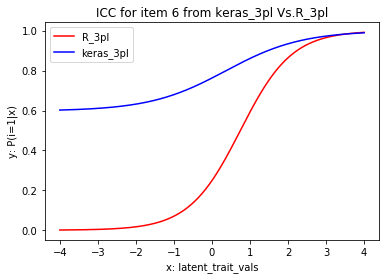

In [182]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 6 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 7

In [60]:
coeff[r_params_cols[0]].iloc[6]

'V7'

In [183]:
c= coeff[r_params_cols[1]].iloc[6]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[6]
b= coeff[r_params_cols[2]].iloc[6]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[6]#values for item 6 from keras 3pl params
a= discrimination_parameters[6]
b= difficulty_level_parameters[6]
vals_keras= logit_func(x)#logits for R's dataframe

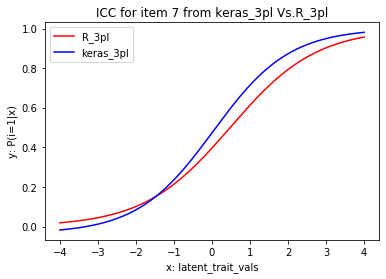

In [184]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 7 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 8

In [185]:
coeff[r_params_cols[0]].iloc[7]

'V8'

In [187]:
c= coeff[r_params_cols[1]].iloc[7]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[7]
b= coeff[r_params_cols[2]].iloc[7]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[7]#values for item 6 from keras 3pl params
a= discrimination_parameters[7]
b= difficulty_level_parameters[7]
vals_keras= logit_func(x)#logits for R's dataframe

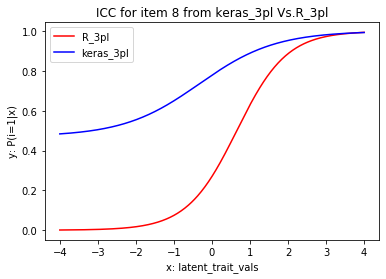

In [188]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 8 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 9

In [67]:
coeff[r_params_cols[0]].iloc[8]

'V9'

In [189]:
c= coeff[r_params_cols[1]].iloc[8]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[8]
b= coeff[r_params_cols[2]].iloc[8]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[8]#values for item 6 from keras 3pl params
a= discrimination_parameters[8]
b= difficulty_level_parameters[8]
vals_keras= logit_func(x)#logits for R's dataframe

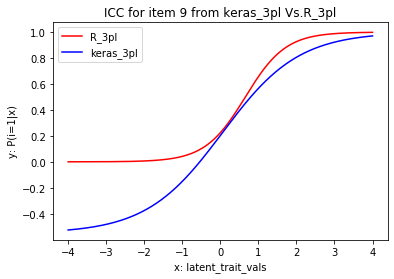

In [190]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 9 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

* calculating plots for R's item 3 & keras's item 10

In [70]:
coeff[r_params_cols[0]].iloc[9]

'V10'

In [191]:
c= coeff[r_params_cols[1]].iloc[9]#values of item 6 from R's dataframe
a= coeff[r_params_cols[-1]].iloc[9]
b= coeff[r_params_cols[2]].iloc[9]
vals_r= logit_func(x)#logits for R's dataframe
###
c= pseudo_guess_parameters[9]#values for item 6 from keras 3pl params
a= discrimination_parameters[9]
b= difficulty_level_parameters[9]
vals_keras= logit_func(x)#logits for R's dataframe

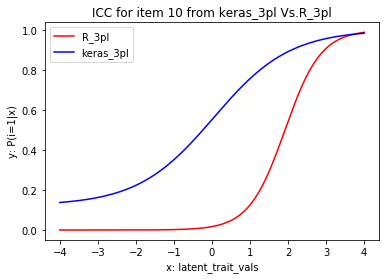

In [192]:
plt.plot(x,vals_r[0], 'r', label='R_3pl')
plt.plot(x,vals_keras[0], 'b', label='keras_3pl')

plt.title('ICC for item 10 from keras_3pl Vs.R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.legend(loc=2)
plt.show()

### Item characteristic curves for all items from R tpm

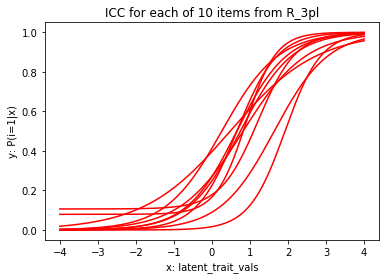

In [193]:
for i in range(coeff.shape[0]):
    c= coeff[r_params_cols[1]].iloc[i]#values of item 6 from R's dataframe
    a= coeff[r_params_cols[-1]].iloc[i]
    b= coeff[r_params_cols[2]].iloc[i]
    vals_r= logit_func(x)
    plt.plot(x,vals_r[0], 'r')

plt.title('ICC for each of 10 items from R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()

### Item characteristic curves for all items from keras 3PL

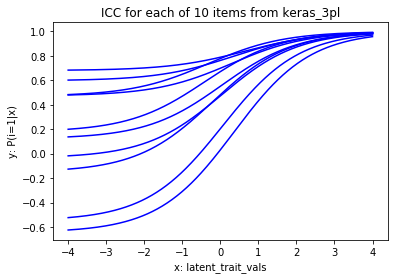

In [194]:
for i in range(len(rel_items)):#10 items
    c= pseudo_guess_parameters[i]#values for item 6 from keras 3pl params
    a= discrimination_parameters[i]
    b= difficulty_level_parameters[i]
    vals_keras= logit_func(x)
    plt.plot(x,vals_keras[0], 'b')

plt.title('ICC for each of 10 items from keras_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()

* Z1 scores from R studio

In [72]:
import pandas as pd

In [73]:
z1= pd.read_csv("z1_score.csv")
z1.head(3)

,Unnamed: 0,score.dat.V1,score.dat.V2,score.dat.V3,score.dat.V4,score.dat.V5,score.dat.V6,score.dat.V7,score.dat.V8,score.dat.V9,score.dat.V10,score.dat.Obs,score.dat.Exp,score.dat.z1,score.dat.se.z1
0,1,0,0,0,0,0,0,0,0,0,0,94,79.728,-0.951585,0.678952
1,2,0,0,0,0,0,0,0,0,1,0,7,6.165,-0.282852,0.530916
2,3,0,0,0,0,0,0,0,1,0,0,2,9.020,-0.382330,0.549916


In [195]:
#z1['score.dat.z1'].values

In [75]:
import matplotlib.pyplot as plt

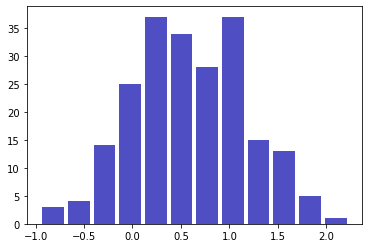

In [77]:
n, bins, patches = plt.hist(x=z1['score.dat.z1'].values, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [78]:
latent_trait_parameters[0].shape

(500, 1)

In [79]:
z1['score.dat.z1'].values.shape

(216,)

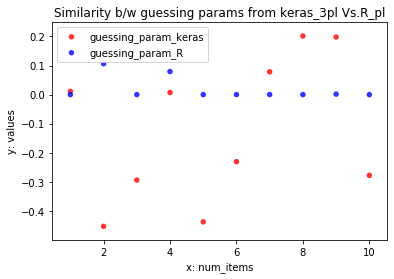

In [80]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
data= (z1['score.dat.z1'].values, latent_trait_parameters[0])
for data, color, group in zip(data_guess, colors, groups):
    x,y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Similarity b/w guessing params from keras_3pl Vs.R_pl')
plt.xlabel('x: num_items')
plt.ylabel('y: values')
plt.legend(loc=2)
plt.show()

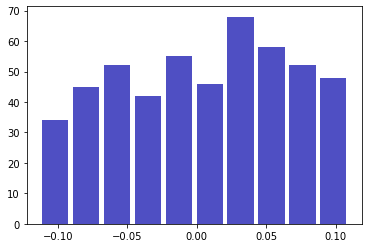

In [81]:
n, bins, patches = plt.hist(x=latent_trait_parameters[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

-------------

### Producing a Simulated dataset

In [86]:
ltrait_new = np.random.normal(0, 1, size=100)
ltrait_new.shape

(100,)

In [111]:
def tpm(diff, latent, guess=0.001, desc=1):
    guess= 0.001 #[0.001]*3#for 3 items
    desc=1 #[1]*3 for 3 items
    prob_per_user = list()
    
    for d in diff:
        prob_per_user.append(guess+ (1- guess)*(np.exp(desc*(latent-d))/(1+np.exp(desc*(latent-d)))))
        
    return prob_per_user

In [112]:
def sim_data(l_trait):
    items= [0,1,2]
    count = l_trait.shape[0]
    data_li= list()
    difficulty= [-0.5,0,0.5]
    for idx, val in enumerate(l_trait):
        data_li= data_li+ list(zip([idx]*3, items, tpm(diff= difficulty, latent= val)))
    
    return data_li

In [120]:
data_list = sim_data(ltrait_new)
df_sim = pd.DataFrame(data_list, columns=['users', 'items', 'responses'])
df_sim = df_sim.loc[np.random.randint(0,df_sim.shape[0]-1, size=df_sim.shape[0])]#shuffling data
df_sim.head(5)

,users,items,responses
168,56,0,0.674052
11,3,2,0.756799
137,45,2,0.391830
144,48,0,0.323055
228,76,0,0.353415


In [123]:
df_sim['responses']=df_sim['responses'].apply(lambda x: np.round(x))
df_sim.head()

,users,items,responses
168,56,0,1.0
11,3,2,1.0
137,45,2,0.0
144,48,0,0.0
228,76,0,0.0
